## ECS 289G - Encoder Decoder (Transformer) With Attention - Coded from scratch with no prior training - Trained directly on Jfleg for Grammar Error Correction

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, Masking, LSTM, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading our dataset JFleg (the preprocessing to make it into csv format was done in my Finetuned T5 code of this project. I am using the same csv dataset)
train_data = pd.read_csv('train.csv')
eval_data = pd.read_csv('eval.csv')

# Preprocessing the data. Here input is the sentence and target is the corrected version
tokenizer_input = Tokenizer()
tokenizer_target = Tokenizer()

tokenizer_input.fit_on_texts(train_data['input'])
tokenizer_target.fit_on_texts(train_data['target'])

input_seq = tokenizer_input.texts_to_sequences(train_data['input'])
target_seq = tokenizer_target.texts_to_sequences(train_data['target'])

max_len_input = max(len(seq) for seq in input_seq)
max_len_target = max(len(seq) for seq in target_seq)

input_seq = pad_sequences(input_seq, maxlen=max_len_input, padding='post')
target_seq = pad_sequences(target_seq, maxlen=max_len_target, padding='post')

# Ensuring consistent lengths for input and target sequences
target_seq = pad_sequences(target_seq, maxlen=max_len_target + 1, padding='post')

In [5]:
# The Transformer model we have built
def build_transformer_model(input_vocab_size, target_vocab_size, d_model=128, nhead=8, ff_dim=512, dropout=0.1, max_len_input=None, max_len_target=None):
    input_layer = Input(shape=(max_len_input,))
    target_layer = Input(shape=(max_len_target,))

    # Embedding layers
    input_embed = Embedding(input_vocab_size, d_model, input_length=max_len_input)(input_layer)
    target_embed = Embedding(target_vocab_size, d_model, input_length=max_len_target)(target_layer)

    # Positional encoding
    pos_encoding = np.zeros((1, max_len_input, d_model))
    for pos in range(max_len_input):
        for i in range(0, d_model, 2):
            pos_encoding[:, pos, i] = np.sin(pos / 10000 ** ((2 * i) / np.float32(d_model)))
            pos_encoding[:, pos, i + 1] = np.cos(pos / 10000 ** ((2 * (i + 1)) / np.float32(d_model)))
    input_embed += pos_encoding

    # Encoder
    encoder = Masking(mask_value=0)(input_embed)
    encoder = LSTM(units=d_model, return_sequences=True)(encoder)

    # Decoder
    decoder = Masking(mask_value=0)(target_embed)
    decoder = LSTM(units=d_model, return_sequences=True)(decoder)

    # Attention mechanism
    attention = Attention(use_scale=True)([decoder, encoder])

    # Apply attention
    context = attention  # Removed Dot layer
    decoder_combined_context = Concatenate(axis=-1)([context, decoder])

    # Feed-forward part
    decoder_combined_context = Dense(ff_dim, activation="relu")(decoder_combined_context)
    decoder_combined_context = Dense(target_vocab_size, activation="softmax")(decoder_combined_context)

    model = Model(inputs=[input_layer, target_layer], outputs=decoder_combined_context)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [6]:
# Training it
model = build_transformer_model(input_vocab_size=len(tokenizer_input.word_index) + 1,
                                target_vocab_size=len(tokenizer_target.word_index) + 1,
                                max_len_input=max_len_input,
                                max_len_target=max_len_target)

history=model.fit([input_seq, target_seq[:, :-1]], np.expand_dims(target_seq[:, 1:], -1), epochs=20, batch_size=64, validation_split=0.2)

# Evaluating
eval_input_seq = tokenizer_input.texts_to_sequences(eval_data['input'])
eval_input_seq = pad_sequences(eval_input_seq, maxlen=max_len_input, padding='post')

eval_target_seq = tokenizer_target.texts_to_sequences(eval_data['target'])
eval_target_seq = pad_sequences(eval_target_seq, maxlen=max_len_target, padding='post')

eval_loss, eval_acc = model.evaluate([eval_input_seq, eval_target_seq[:, :-1]], np.expand_dims(eval_target_seq[:, 1:], -1))
print(f'Evaluation Loss: {eval_loss}, Evaluation Accuracy: {eval_acc}')

model.save('grammar_correction_model.h5')

Epoch 1/20
38/38 [==============================] - 70s 2s/step - loss: 2.8687 - accuracy: 0.7660 - val_loss: 1.4943 - val_accuracy: 0.7944
Epoch 2/20
38/38 [==============================] - 58s 2s/step - loss: 1.4414 - accuracy: 0.7864 - val_loss: 1.4095 - val_accuracy: 0.7944
Epoch 3/20
38/38 [==============================] - 57s 2s/step - loss: 1.3769 - accuracy: 0.7877 - val_loss: 1.3977 - val_accuracy: 0.7978
Epoch 4/20
38/38 [==============================] - 57s 2s/step - loss: 1.3525 - accuracy: 0.7934 - val_loss: 1.4207 - val_accuracy: 0.7980
Epoch 5/20
38/38 [==============================] - 57s 2s/step - loss: 1.3366 - accuracy: 0.7945 - val_loss: 1.4518 - val_accuracy: 0.7977
Epoch 6/20
38/38 [==============================] - 57s 2s/step - loss: 1.3243 - accuracy: 0.7951 - val_loss: 1.4890 - val_accuracy: 0.7967
Epoch 7/20
38/38 [==============================] - 62s 2s/step - loss: 1.3124 - accuracy: 0.7957 - val_loss: 1.5069 - val_accuracy: 0.7969
Epoch 8/20
38/38 [==

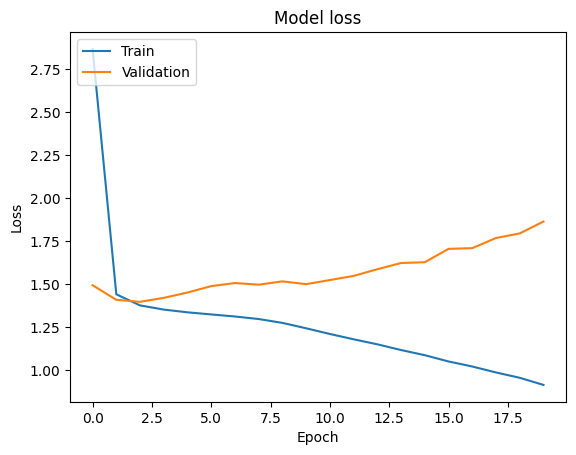

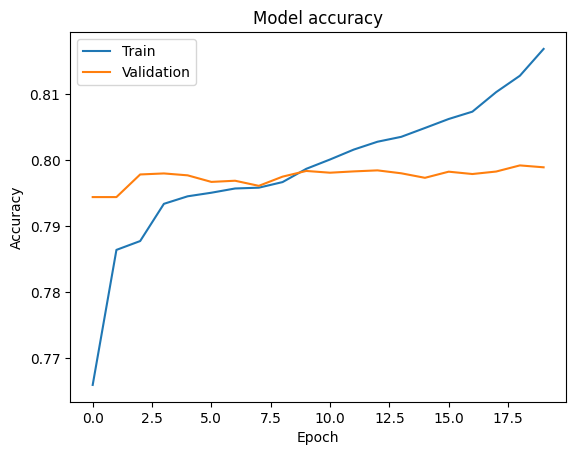

In [7]:
import matplotlib.pyplot as plt
# PLotting the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
model.save('grammar_correction_model.h5')

In [9]:
!pip install nltk

In [10]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.gleu_score import sentence_gleu

In [13]:
# Generating predictions on the evaluation data ( to calculate our bleu and gleu)
eval_input_seq = tokenizer_input.texts_to_sequences(eval_data['input'])
eval_target_seq = tokenizer_target.texts_to_sequences(eval_data['target'])

# Pad evaluation sequences to match the expected input shape
eval_input_seq = pad_sequences(eval_input_seq, maxlen=max_len_input, padding='post')
eval_target_seq = pad_sequences(eval_target_seq, maxlen=max_len_target, padding='post')

eval_target_seq = pad_sequences(eval_target_seq, maxlen=max_len_target+1, padding='post')


# Generate predictions on the evaluation data
predictions = model.predict([eval_input_seq, eval_target_seq[:, :-1]])

# Convert predictions to token indices
predicted_token_indices = np.argmax(predictions, axis=-1)

# Convert token indices back to text
predicted_texts = tokenizer_target.sequences_to_texts(predicted_token_indices)
eval_texts = tokenizer_target.sequences_to_texts(eval_target_seq[:, 1:])








94/94 [==============================] - 22s 235ms/step


In [14]:
# Calculate BLEU score
bleu_score = corpus_bleu([[seq.split()] for seq in eval_texts], [seq.split() for seq in predicted_texts])
print(f'BLEU Score: {bleu_score}')

# Calculate GLEU score
gleu_score = np.mean([sentence_gleu([seq.split()], seq_pred.split()) for seq, seq_pred in zip(eval_texts, predicted_texts)])
print(f'GLEU Score: {gleu_score}')

BLEU Score: 0.005842546796681036
GLEU Score: 0.04666665602239449
